First we will mount our google drive on colab so that we can use the dataset directly from our drive. For this you first need to upload the data on your drive and then mount the drive on colab.

After mounting our drive we will locate the folder where our data is stored to use it in our colab notebook.
Here you can see that I have 2 folders in my drive and 'Plant_images_pianlytix'  contains the images that we will work on.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os

from os import listdir
from PIL import Image
from sklearn.preprocessing import label_binarize,  LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical 

Using TensorFlow backend.


Next we will import all the required libraries. As we are making a CNN model we will import all the required layers, activations, optimizers, etc.  

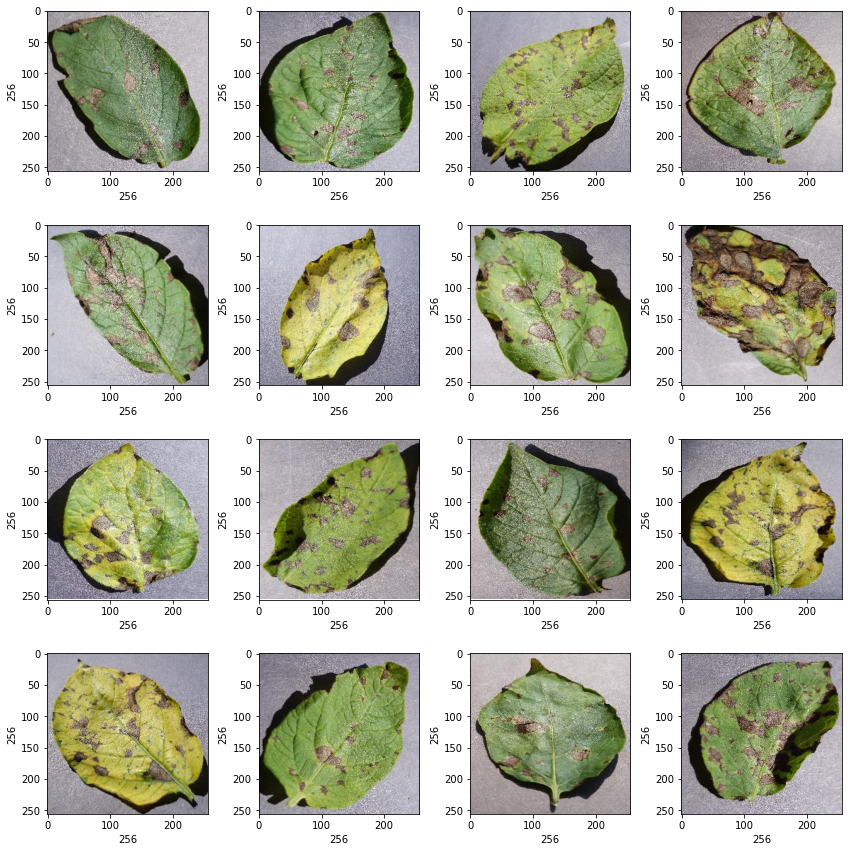

In [2]:
# Plotting 12 images to check dataset
plt.figure(figsize=(12,12))
path = "Data/Plant_images/Potato___Early_blight"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

Now we will observe some of the iamges that are their in our dataset. We will plot 12 images here using the matplotlib library.

In [3]:
#Converting Images to array 
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (256,256))  
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

After visualizing the images let us move forward and create a function which will convert the images into a numpy array. It is required because we will normalize our dataset after this.

In [4]:
dir = "Data/Plant_images"
root_dir = listdir(dir)
image_list, label_list = [], []
all_labels = ['Corn-Common_rust', 'Potato-Early_blight', 'Tomato-Bacterial_spot']
binary_labels = [0,1,2]
temp = -1

# Reading and converting image to numpy array
for directory in root_dir:
  plant_image_list = listdir(f"{dir}/{directory}")
  temp += 1
  for files in plant_image_list:
    image_path = f"{dir}/{directory}/{files}"
    image_list.append(convert_image_to_array(image_path))
    label_list.append(binary_labels[temp])

Now we will convert all the images into numpy array.

We will also observe the number of images under different classes to see if the dataset is balanced or not

In [6]:
image_list[0].shape

(256, 256, 3)

Next we will observe the shape of the image.

In [7]:
label_list = np.array(label_list)
label_list.shape

(900,)

Checking the total number of the images which is the length of the labels list.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10) 

Next we will use sklearn train_test_split to split the dataset into testing and training data. Here I have taken test size as 0.2 so my data will be divided into 80% training and 20% testing data.

In [9]:
x_train = np.array(x_train, dtype=np.float16) / 225.0
x_test = np.array(x_test, dtype=np.float16) / 225.0
x_train = x_train.reshape( -1, 256,256,3)
x_test = x_test.reshape( -1, 256,256,3)

Now we will normalize the dataset of our images. As pixel values ranges from 0 to 255 so we will divide each image pixel with 255 to normalize the dataset.

In [10]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(256,256,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dense(3, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28224)             0         
_________________________________________________________________
dense (Dense)                (None, 8)                 225800    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 2

Next we will create a network architecture for the model. We have used different types of layers according to their features namely Conv_2d (It is used to create a convolutional kernel that is convolved with the input layer to produce the output tensor), max_pooling2d (It is a downsampling technique which takes out the maximum value over the window defined by poolsize), flatten (It flattens the input and creates a 1D output), Dense (Dense layer produce the output as the dot product of input and kernel).


In [12]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

While compiling the model we need to set the type of loss which will be Binary Crossentropy for our model alongwith this we also need to set the optimizer and the metrics respectively.

In [13]:
# Splitting the training data set into training and validation data sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

Next we will split the dataset into validation and training data.

In [14]:
# Training the model
epochs = 50
batch_size = 128
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (x_val, y_val))

Epoch 1/50
5/5 [==============================] - 86s 17s/step - loss: 1.0658 - accuracy: 0.4062 - val_loss: 0.9515 - val_accuracy: 0.5903
Epoch 2/50
5/5 [==============================] - 31s 6s/step - loss: 0.9133 - accuracy: 0.6406 - val_loss: 0.8430 - val_accuracy: 0.6458
Epoch 3/50
5/5 [==============================] - 29s 6s/step - loss: 0.8007 - accuracy: 0.6406 - val_loss: 0.6944 - val_accuracy: 0.6458
Epoch 4/50
5/5 [==============================] - 28s 6s/step - loss: 0.6643 - accuracy: 0.6580 - val_loss: 0.6026 - val_accuracy: 0.6528
Epoch 5/50
5/5 [==============================] - 33s 7s/step - loss: 0.5725 - accuracy: 0.6580 - val_loss: 0.5285 - val_accuracy: 0.6528
Epoch 6/50
5/5 [==============================] - 34s 7s/step - loss: 0.5099 - accuracy: 0.6510 - val_loss: 0.4742 - val_accuracy: 0.6528
Epoch 7/50
5/5 [==============================] - 37s 7s/step - loss: 0.4610 - accuracy: 0.6615 - val_loss: 0.4344 - val_accuracy: 0.6528
Epoch 8/50
5/5 [=================

Fitting the model with the data and finding out the accuracy at each epoch to see how our model is learning. Now we will train our model on 10 epochs and a batch size of 128. You can try using more number of epochs to increase accuracy but here we can see that the model has already raeched a very high accuracy so we don't need to run it for more. During each epochs we can see how the model is performing by viewing the training and validation accuracy.

In [15]:
model.save("plant_disease.h5")
json_model = model.to_json()
#save the model architecture to JSON file
with open('plant_model.json', 'w') as json_file:
    json_file.write(json_model)
#saving the weights of the model
model.save_weights('plant_model_weights.h5')

Saving the model using different techniques.

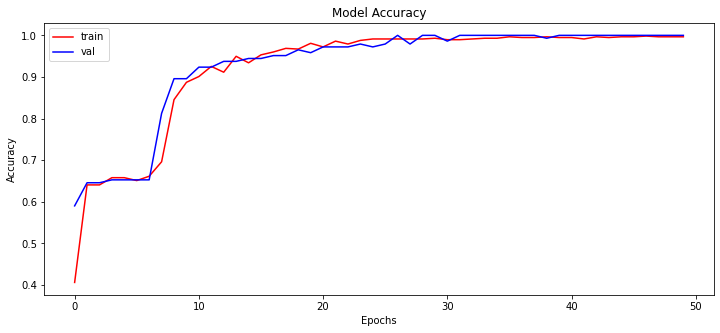

In [16]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

Next we will plot the accuracy of the model for the trainig history.

In [17]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
6/6 [==============================] - 2s 401ms/step - loss: 0.0351 - accuracy: 0.9778
Test Accuracy: 97.77777791023254


Evaluating the model to know the accuracy of the model.


In [18]:
y_pred = model.predict(x_test)

Next we will use our model to predict predicting the testing dataset label.

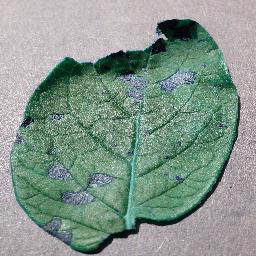

In [19]:
# Plotting image to compare
img = array_to_img(x_test[10])
img

In [20]:
# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",all_labels[np.argmax(y_test[10])])
print("Predicted : ",all_labels[np.argmax(y_pred[10])])

Originally :  Potato-Early_blight
Predicted :  Potato-Early_blight


Printing out the original and the predicted label.

## Conclusion

We started with loading the dataset into google colab using google drive and visualizing the images. Normalizing is an important step when working with any type of dataset. After that we created a CNN Model which is further used for predicting the plant diseases using the image supplied to model.
This model is highly beneficial as it can be used by different agricultural firms and farmers to increase their yield and stop wastage of crops due to disease.